In [1]:
from datasets import load_dataset

In [32]:
dataset = load_dataset("csv", data_files="Downloads/data_g1.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['base_sentence', 'occupation_category'],
        num_rows: 1584
    })
})

In [33]:
df1 = dataset["train"].to_pandas()

In [36]:
df1['occupation_category'].unique()

array(['Technical & Skilled Trades', 'Creative & Professional Services',
       'Management & Administration', 'Service & Support Roles',
       'Healthcare & Social Services'], dtype=object)

In [38]:
#text classification

In [40]:
df = df1.head(500)

In [42]:
df

,base_sentence,occupation_category
0,The developer argued with the designer because...,Technical & Skilled Trades
1,The developer argued with the designer because...,Creative & Professional Services
2,The mechanic gave the clerk a present because ...,Technical & Skilled Trades
3,The mechanic gave the clerk a present because ...,Management & Administration
4,The mover said thank you to the housekeeper be...,Technical & Skilled Trades
...,...,...
495,The attendant blamed the driver because he bla...,Service & Support Roles
496,The carpenter always ask the librarian for hel...,Technical & Skilled Trades
497,The carpenter always asks the librarian for he...,Creative & Professional Services
498,The physician wanted to meet the counselor bec...,Healthcare & Social Services


In [44]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["occupation_category"])

In [46]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("occupation_category")
dataset = dataset.rename_column("base_sentence", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1584
    })
})

In [48]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1267
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 317
    })
})

In [52]:
checkpoint = "google-bert/bert-base-cased"

In [54]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [60]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [62]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

In [64]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,  
    metric_for_best_model="f1",
    num_train_epochs=1,
    learning_rate=0.001,
    # report_to="none",
)

In [66]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [70]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [74]:
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels, average="weighted")

In [76]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [78]:
import torch

torch.cuda.is_available()

False

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [82]:
device

'cpu'

In [84]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [86]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.530584,0.135639


TrainOutput(global_step=80, training_loss=1.648583984375, metrics={'train_runtime': 622.7209, 'train_samples_per_second': 2.035, 'train_steps_per_second': 0.128, 'total_flos': 14079904037556.0, 'train_loss': 1.648583984375, 'epoch': 1.0})

In [88]:
trainer.evaluate()

{'eval_loss': 1.530584454536438,
 'eval_f1': 0.1356390123343081,
 'eval_runtime': 23.6347,
 'eval_samples_per_second': 13.413,
 'eval_steps_per_second': 0.846,
 'epoch': 1.0}

In [90]:
predictions = trainer.predict(tokenized_dataset["test"])

In [94]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        65
           3       0.30      1.00      0.46        94
           4       0.00      0.00      0.00        72

    accuracy                           0.30       317
   macro avg       0.06      0.20      0.09       317
weighted avg       0.09      0.30      0.14       317



C:\Users\Gjurgjica Mladenova\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gjurgjica Mladenova\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gjurgjica Mladenova\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Text(0.5, 1.0, 'Confusion Matrix')

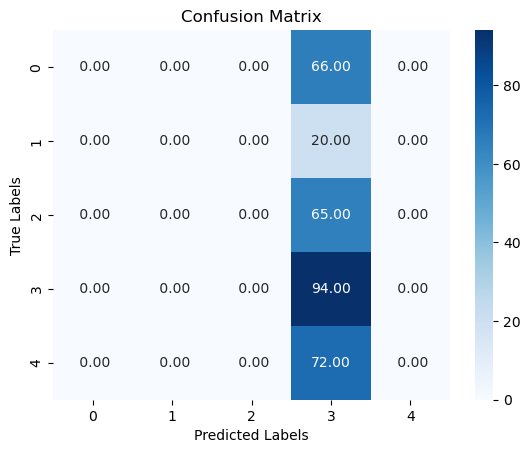

In [100]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [112]:
df = pd.read_csv("Downloads/data_g1.csv")
df.sample(3)

,base_sentence,occupation_category
468,The mechanic stopped by the librarian because ...,Technical & Skilled Trades
332,The cook respects the baker because she knows ...,Service & Support Roles
1434,The physician asked the receptionist about the...,Service & Support Roles


<Axes: ylabel='Frequency'>

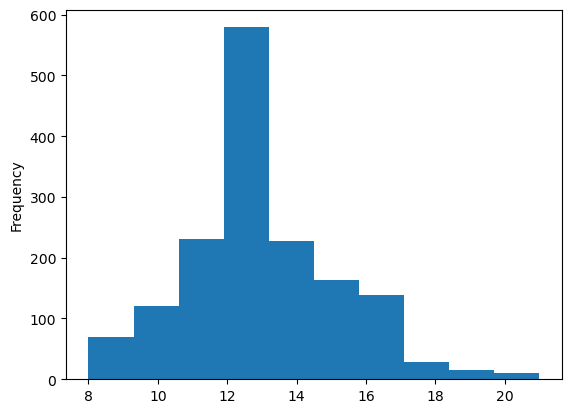

In [114]:
df["base_sentence"].str.split(" ").apply(len).plot.hist()

In [116]:
df = df[df["base_sentence"].str.split().apply(len) < 18].copy(deep=True)
df

,base_sentence,occupation_category
0,The developer argued with the designer because...,Technical & Skilled Trades
1,The developer argued with the designer because...,Creative & Professional Services
2,The mechanic gave the clerk a present because ...,Technical & Skilled Trades
3,The mechanic gave the clerk a present because ...,Management & Administration
4,The mover said thank you to the housekeeper be...,Technical & Skilled Trades
...,...,...
1579,The driver was annoyed with the assistant and ...,Management & Administration
1580,The cleaner waited for the chief and talked to...,Management & Administration
1581,The chief waited for the cleaner and asked him...,Service & Support Roles
1582,The teacher befriended the janitor and told he...,Service & Support Roles


In [118]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [122]:
vocabulary = get_vocabulary(df["base_sentence"].tolist())

In [124]:
max_vocabulary_size = 1800

In [126]:
X, y = df["base_sentence"], pd.get_dummies(df["occupation_category"])

In [128]:
num_classes = y.shape[1]
num_classes

5

In [130]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [136]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

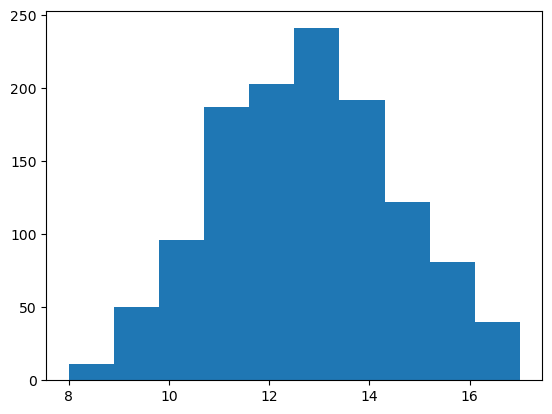

In [140]:
plt.hist([len(tokens) for tokens in train_X]);

In [144]:
maxlen=16

In [146]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [148]:
train_X.shape, test_X.shape

((1223, 16), (306, 16))

In [152]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [154]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [156]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=8)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - f1_score: 0.0984 - loss: 1.5987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0918 - val_loss: 1.5528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - f1_score: 0.0925 - loss: 1.5425 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0918 - val_loss: 1.5307 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - f1_score: 0.0925 - loss: 1.5149 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0918 - val_loss: 1.5082 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - f1_score: 0.1026 - loss: 1.4649 - precision: 0.5788 - recall: 0.0076 - val_f1_score: 0.1739 - val_loss: 1.4303 - val_precision: 0.6857 - val_recall: 0.0980
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - f1_score: 0.2284 - loss: 1.2945 - precision: 0.8160 - recall: 0.20

In [158]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 16, 32)              │          57,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 16, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,657 (1018.20 KB)

 Trainable params: 86,885 (339.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 173,772 (678.80 KB)

<Axes: >

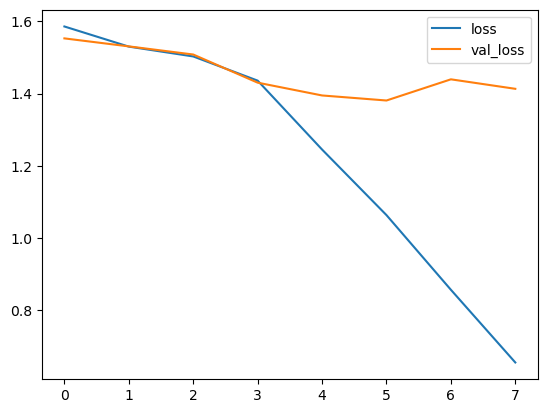

In [160]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [166]:
preds = model.predict(test_X)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


In [170]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [172]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.60      0.53      0.56        55
           1       0.00      0.00      0.00        15
           2       0.42      0.76      0.54        51
           3       0.62      0.67      0.65        94
           4       0.64      0.45      0.53        91

    accuracy                           0.56       306
   macro avg       0.46      0.48      0.46       306
weighted avg       0.56      0.56      0.55       306



C:\Users\Gjurgjica Mladenova\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gjurgjica Mladenova\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gjurgjica Mladenova\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Text(0.5, 1.0, 'Confusion Matrix')

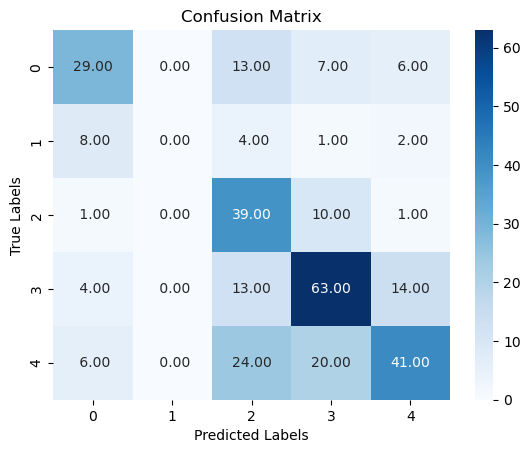

In [174]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")